In [67]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

import lightgbm as lgb

In [ ]:
df = pd.read_csv("../../data/accident_data_with_vehicle_data_further_cleaned_w_stations_n_non_accidents_weather_merged_cleaned.csv")

df.shape

In [47]:
# convert categorical variable into indicator variables for classification

df = pd.get_dummies(df)
df.columns

Index(['longitude', 'latitude', 'accident_severity', 'day_of_week',
       'speed_limit', 'urban_or_rural_area', 'year', 'hour', 'day_of_year',
       'cluster_1', 'vehicle_type', 'sex_of_driver', 'age_of_driver',
       'engine_capacity_(cc)', 'age_of_vehicle', 'driver_home_area_type',
       'accident', 'wind_direction', 'wind_speed', 'air_temperature',
       'dewpoint', 'wetb_temp', 'rltv_hum', 'ground_state_id',
       'cld_ttl_amt_id', 'road_surface_conditions_Dry',
       'road_surface_conditions_Flood (Over 3cm of water)',
       'road_surface_conditions_Frost/Ice', 'road_surface_conditions_Snow',
       'road_surface_conditions_Wet/Damp'],
      dtype='object')

In [ ]:
df.describe()

<AxesSubplot:xlabel='accident', ylabel='count'>

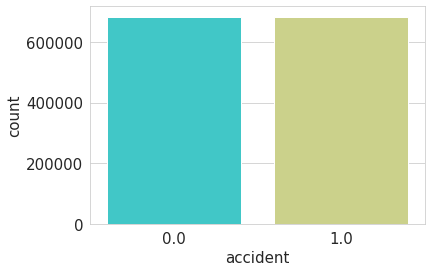

In [49]:
# both accident and non-accident sizes are balanced (un-biased)
sns.set_style('whitegrid')
sns.countplot(x='accident',data=df,palette='rainbow')

<AxesSubplot:>

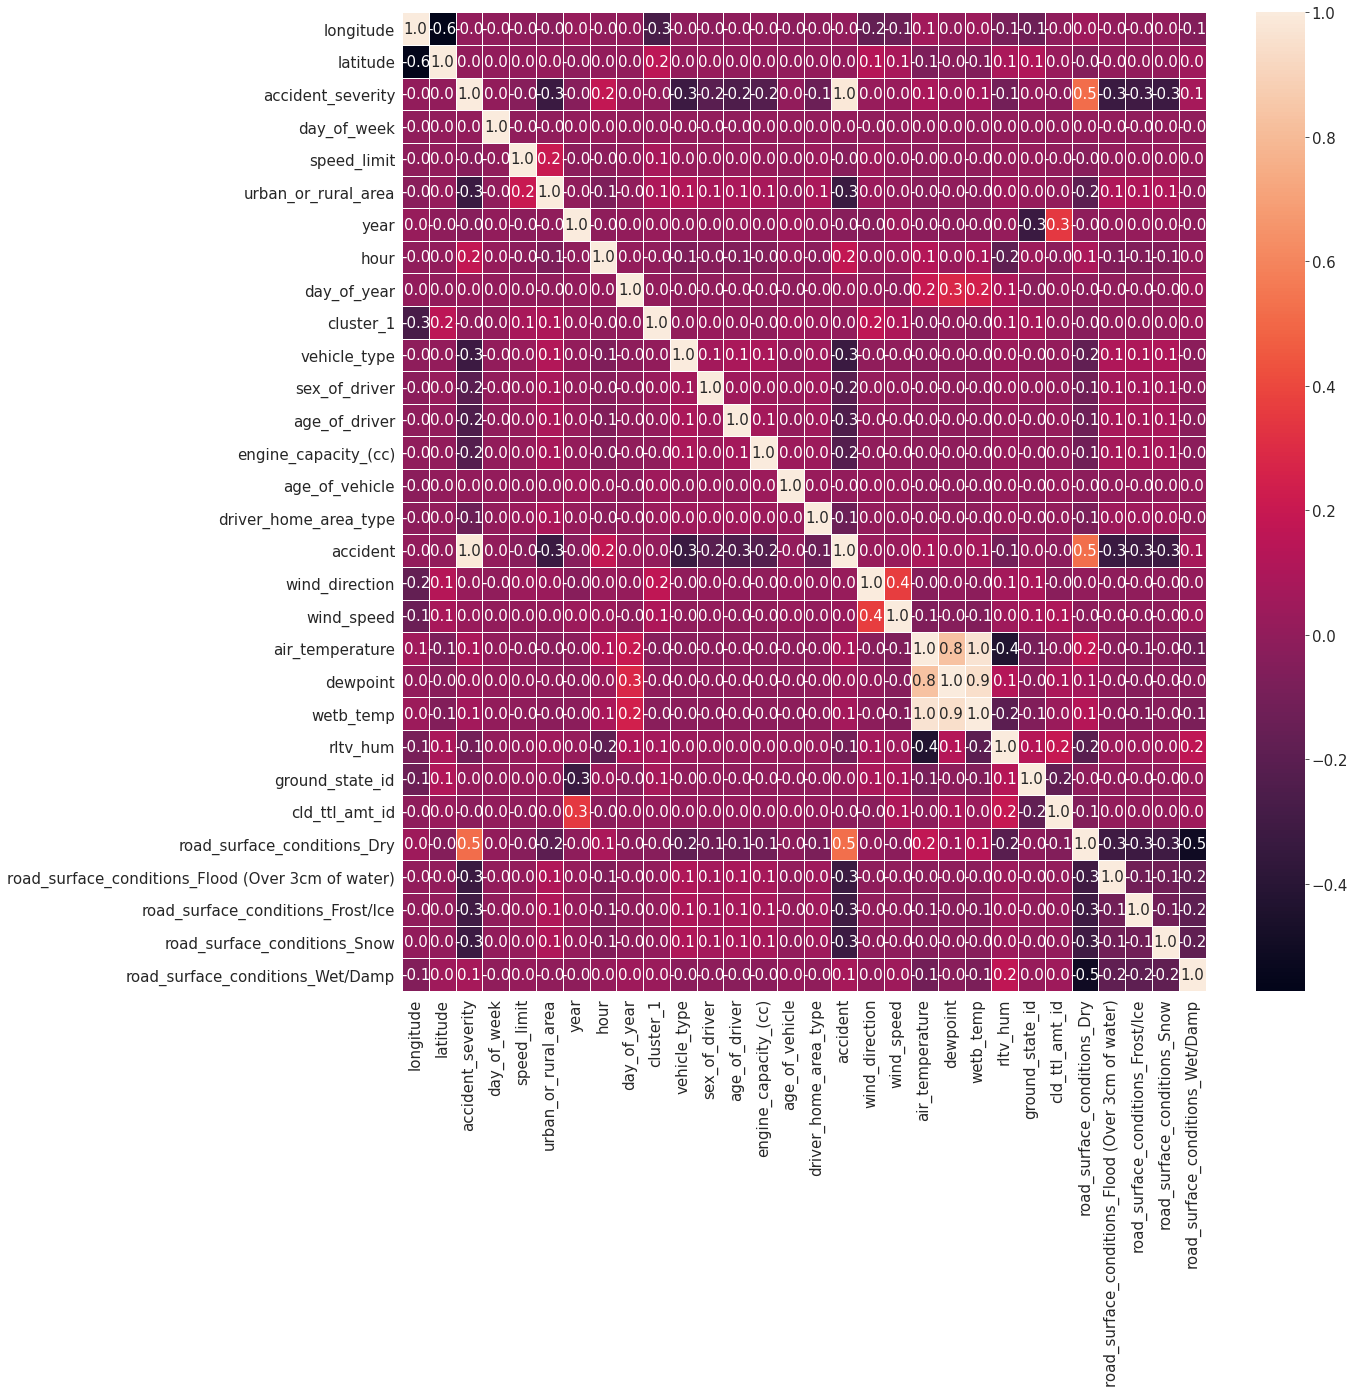

In [50]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

### remove higly coorelated featrues

In [52]:
corr_matrix = df.corr().abs()
corr_matrix

,longitude,latitude,accident_severity,day_of_week,speed_limit,urban_or_rural_area,year,hour,day_of_year,cluster_1,...,dewpoint,wetb_temp,rltv_hum,ground_state_id,cld_ttl_amt_id,road_surface_conditions_Dry,road_surface_conditions_Flood (Over 3cm of water),road_surface_conditions_Frost/Ice,road_surface_conditions_Snow,road_surface_conditions_Wet/Damp
longitude,1.000000,0.571856,0.000726,0.003263,0.011755,0.029893,0.022658,0.006041,0.001096,0.272926,...,0.005185,0.036244,0.092319,0.133372,0.011512,0.046369,0.000719,0.003648,0.000067,0.051725
latitude,0.571856,1.000000,0.000082,0.005057,0.002285,0.014141,0.012947,0.004571,0.001222,0.153614,...,0.026513,0.055227,0.085421,0.111951,0.024933,0.044991,0.000235,0.004151,0.000727,0.049839
accident_severity,0.000726,0.000082,1.000000,0.000231,0.033984,0.330674,0.035884,0.177316,0.020736,0.001405,...,0.033199,0.066417,0.106016,0.012422,0.023619,0.517333,0.327665,0.305905,0.321003,0.074492
day_of_week,0.003263,0.005057,0.000231,1.000000,0.003627,0.005513,0.000176,0.011601,0.001061,0.002201,...,0.006637,0.004744,0.004541,0.002691,0.002161,0.001712,0.000032,0.001064,0.000195,0.001368
speed_limit,0.011755,0.002285,0.033984,0.003627,1.000000,0.205675,0.022593,0.016526,0.000127,0.081448,...,0.000114,0.004095,0.012818,0.014558,0.003115,0.034719,0.011083,0.012633,0.012090,0.015300
urban_or_rural_area,0.029893,0.014141,0.330674,0.005513,0.205675,1.000000,0.001769,0.070583,0.006696,0.102369,...,0.006308,0.021124,0.045660,0.012334,0.009665,0.194584,0.111470,0.105914,0.108196,0.003975
year,0.022658,0.012947,0.035884,0.000176,0.022593,0.001769,1.000000,0.008125,0.002151,0.021397,...,0.018390,0.022187,0.016219,0.330754,0.347044,0.012826,0.011993,0.011722,0.013300,0.011447
hour,0.006041,0.004571,0.177316,0.011601,0.016526,0.070583,0.008125,1.000000,0.005391,0.000862,...,0.024508,0.083013,0.189338,0.040955,0.024436,0.097008,0.060316,0.060879,0.055916,0.012658
day_of_year,0.001096,0.001222,0.020736,0.001061,0.000127,0.006696,0.002151,0.005391,1.000000,0.002438,...,0.278942,0.244033,0.100182,0.026565,0.016407,0.022406,0.006761,0.007281,0.009076,0.043129
cluster_1,0.272926,0.153614,0.001405,0.002201,0.081448,0.102369,0.021397,0.000862,0.002438,1.000000,...,0.003734,0.026790,0.069780,0.078399,0.015573,0.033085,0.001669,0.003714,0.000239,0.035069


In [53]:
corr = corr_matrix.abs().unstack()
corr

longitude                         longitude                                            1.000000
                                  latitude                                             0.571856
                                  accident_severity                                    0.000726
                                  day_of_week                                          0.003263
                                  speed_limit                                          0.011755
                                                                                         ...   
road_surface_conditions_Wet/Damp  road_surface_conditions_Dry                          0.507703
                                  road_surface_conditions_Flood (Over 3cm of water)    0.182897
                                  road_surface_conditions_Frost/Ice                    0.187935
                                  road_surface_conditions_Snow                         0.184544
                                  road_s

In [54]:
labels_to_drop = set()
cols = df.columns
for i in range(0, df.shape[1]):
    for j in range(0, i+1):
        labels_to_drop.add((cols[i], cols[j]))

corr = corr.drop(labels=labels_to_drop).sort_values(ascending=False)

# top correlated pairs
corr[0:15]

accident_severity            accident                                             0.986156
air_temperature              wetb_temp                                            0.963214
dewpoint                     wetb_temp                                            0.945065
air_temperature              dewpoint                                             0.832166
longitude                    latitude                                             0.571856
accident                     road_surface_conditions_Dry                          0.525550
accident_severity            road_surface_conditions_Dry                          0.517333
road_surface_conditions_Dry  road_surface_conditions_Wet/Damp                     0.507703
air_temperature              rltv_hum                                             0.431224
wind_direction               wind_speed                                           0.362892
year                         cld_ttl_amt_id                                       0.347044

In [55]:
# remove labels with coorelation > .95
to_drop = ['accident_severity','wetb_temp']

# drop features 
df.drop(to_drop, axis=1, inplace=True)

In [56]:
df.columns

Index(['longitude', 'latitude', 'day_of_week', 'speed_limit',
       'urban_or_rural_area', 'year', 'hour', 'day_of_year', 'cluster_1',
       'vehicle_type', 'sex_of_driver', 'age_of_driver',
       'engine_capacity_(cc)', 'age_of_vehicle', 'driver_home_area_type',
       'accident', 'wind_direction', 'wind_speed', 'air_temperature',
       'dewpoint', 'rltv_hum', 'ground_state_id', 'cld_ttl_amt_id',
       'road_surface_conditions_Dry',
       'road_surface_conditions_Flood (Over 3cm of water)',
       'road_surface_conditions_Frost/Ice', 'road_surface_conditions_Snow',
       'road_surface_conditions_Wet/Damp'],
      dtype='object')

### data split

In [57]:
all_feature_cols = list(df.columns)
all_feature_cols.remove('accident')

X = df[all_feature_cols] 
y = df['accident']

# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('X_train dimension = ', X_train.shape)
print('X_test  dimension = ', X_test.shape)
print('y_train dimension = ', y_train.shape)
print('y_train dimension = ', y_test.shape)

X_train dimension =  (955122, 27)
X_test  dimension =  (409338, 27)
y_train dimension =  (955122,)
y_train dimension =  (409338,)


### Feature selection with feature importance

In [58]:
feature_importances = np.zeros(X_train.shape[1])

model = lgb.LGBMClassifier(objective='binary', 
                           boosting_type = 'goss', 
                           n_estimators = 10000, 
                           class_weight = 'balanced')

In [59]:
model.fit(X_train, 
          y_train, 
          early_stopping_rounds=100, 
          eval_set = [(X_test, y_test)], 
          eval_metric = 'auc', 
          verbose = 200)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.999744	valid_0's binary_logloss: 0.0184412
[400]	valid_0's auc: 0.999799	valid_0's binary_logloss: 0.0159086
[600]	valid_0's auc: 0.999818	valid_0's binary_logloss: 0.0149162
[800]	valid_0's auc: 0.999826	valid_0's binary_logloss: 0.0144005
[1000]	valid_0's auc: 0.999834	valid_0's binary_logloss: 0.014005
[1200]	valid_0's auc: 0.999837	valid_0's binary_logloss: 0.0137541
[1400]	valid_0's auc: 0.999842	valid_0's binary_logloss: 0.0135308
[1600]	valid_0's auc: 0.999845	valid_0's binary_logloss: 0.0133813
[1800]	valid_0's auc: 0.999848	valid_0's binary_logloss: 0.013334
[2000]	valid_0's auc: 0.99985	valid_0's binary_logloss: 0.0133058
Early stopping, best iteration is:
[1995]	valid_0's auc: 0.99985	valid_0's binary_logloss: 0.0133029


LGBMClassifier(boosting_type='goss', class_weight='balanced',
               n_estimators=10000, objective='binary')

In [60]:
feature_importances = model.feature_importances_ 
feature_importances = pd.DataFrame(
    {'feature': all_feature_cols, 
     'importance': feature_importances}
).sort_values('importance', ascending = False)
feature_importances

,feature,importance
12,engine_capacity_(cc),8574
9,vehicle_type,4066
1,latitude,3826
11,age_of_driver,3778
0,longitude,3598
8,cluster_1,3342
7,day_of_year,3019
19,rltv_hum,2689
18,dewpoint,2417
20,ground_state_id,2416


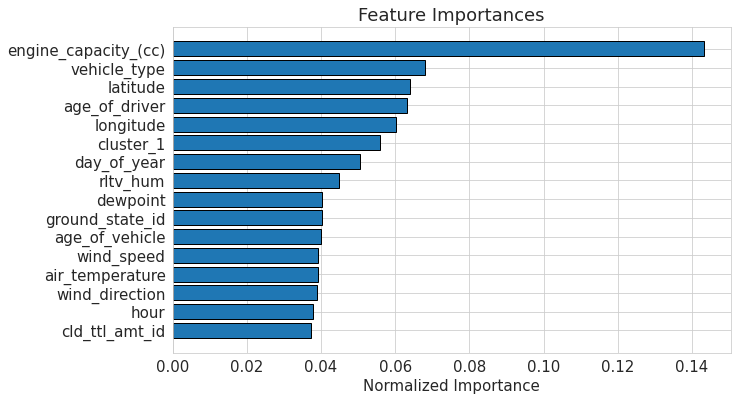

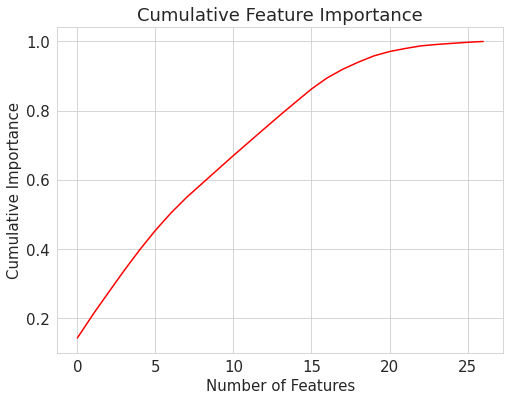

20 features required for 0.95 of cumulative importance


In [61]:
# select top 16 features
def plot_feature_importances(df, threshold = 0.9):    
    plt.rcParams['font.size'] = 15
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    ax.barh(list(reversed(list(df.index[:16]))), 
            df['importance_normalized'].head(16), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:16]))))
    ax.set_yticklabels(df['feature'].head(16))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

In [62]:
# top features

top_feature_cols = list((feature_importances).feature[0:16])
top_feature_cols

['engine_capacity_(cc)',
 'vehicle_type',
 'latitude',
 'age_of_driver',
 'longitude',
 'cluster_1',
 'day_of_year',
 'rltv_hum',
 'dewpoint',
 'ground_state_id',
 'age_of_vehicle',
 'wind_speed',
 'air_temperature',
 'wind_direction',
 'hour',
 'cld_ttl_amt_id']

In [63]:
classification_ready_features = top_feature_cols
classification_ready_features.append('accident')

In [64]:
classification_ready_data = df[classification_ready_features]
classification_ready_data.sample(6)

,engine_capacity_(cc),vehicle_type,latitude,age_of_driver,longitude,cluster_1,day_of_year,rltv_hum,dewpoint,ground_state_id,age_of_vehicle,wind_speed,air_temperature,wind_direction,hour,cld_ttl_amt_id,accident
1297455,3940.0,18.0,53.466370,86.0,-2.233858,50378.0,164.0,57.300000,7.000000,8.211871,-1.0,9.000000,15.200000,280.000000,19.0,0.000000,0.0
824631,2231.0,19.0,51.452269,100.0,-0.147864,2260.0,23.0,73.400000,2.200000,8.211165,3.0,0.000000,6.600000,0.000000,3.0,6.187132,0.0
983721,2157.0,3.0,51.516833,53.0,0.010709,32338.0,221.0,54.500000,8.700000,1.000000,-1.0,4.000000,17.900000,330.000000,9.0,3.000000,0.0
37976,1796.0,9.0,52.580348,63.0,-2.125705,15605.0,231.0,73.847120,11.762323,8.179343,5.0,11.287756,16.444189,163.649358,17.0,5.427251,1.0
53885,2151.0,19.0,52.502740,45.0,-1.991423,16029.0,12.0,84.595222,1.874350,6.125181,4.0,16.859598,4.286735,235.584311,12.0,2.959274,1.0
1154942,2967.0,4.0,54.778486,11.0,-1.562953,11458.0,42.0,97.900000,-0.200000,8.710682,6.0,6.000000,0.000000,90.000000,17.0,7.771850,0.0


In [65]:
classification_ready_data.shape

(1364460, 17)

In [66]:
classification_ready_data.to_csv("../../data/classification_ready_data.csv", index=False)